In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.animation as animation

import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, SkyOffsetFrame


from scipy.sparse.linalg import eigsh
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.sparse.linalg import svds
from scipy.interpolate import griddata

import time as timer
import sys

from scintools.ththmod import fft_axis, ext_find

In [2]:
sys.path.append('..')  # Add parent directory to the system path
sys.path.append('/home/montalvo/Pyspace/Scintillometry/Double_Pulsar')

In [3]:
from pint.models import get_model
from RickettTables import fitvals
from RickettEquations import *
from Curvature import *

In [4]:
from Funcs_DP import *
from Funcs_DP_Orbsim import *
from Funcs_DP_Sspec import *
from Funcs_DP_thth import *
from Aux_funcs import *
from screens_binary import *

In [5]:
par = 'J0737-3039A-2021.par'

psr_m = get_model(par)

psr = SkyCoord(ra=str(psr_m.RAJ.quantity), dec=str(psr_m.DECJ.quantity),
                   pm_ra_cosdec=psr_m.PMRA.quantity, pm_dec=psr_m.PMDEC.quantity)

def Eart_ad(mjd_t):
    
    #earth velocities in ra/dec in km/s but are unitless
    VE_a = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][0].value
    VE_dec = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][1].value
    
    return VE_a, VE_dec

## Set a seed for your randomized numbers

In [6]:
np.random.seed(12345)

In [7]:
#distances"
d_p = 1.0 * u.kpc
d_s = 0.5 * u.kpc


#velocities
ear_v = np.array([ -19.458047552, -14.826295740, 0. ]) * u.km/ u.s 
scr_v = -10. * u.km / u.s

#positions
p_pos = np.array([0,0,0]) * u.au
e_pos = np.array([0,0,0]) * u.au
N1 = 19
screen1_pos = np.linspace(-2, 2, N1) << u.au 

#screen 1 sigma and magnification amplitude
sig1 = 1.
amp1 = 0.05


#screen params
scr_normal = CylindricalRepresentation(1., 65*u.deg, 0.).to_cartesian()

#time and freq
freq = np.linspace(315*u.MHz, 317*u.MHz, 500)
t = np.linspace(0, 3. * u.hour, 1350).to(u.min)

In [8]:
## orbital params
#orb period
Pba = 2.45 * u.hour
#long of asc. node
Op = 60. * u.deg
#inclination angle
inc = 91. * u.deg
#proper velocity
Va = -17.8 * u.km / u.s
Vd = 11.6 * u.km / u.s

#true anomaly and orbital phase 
nu = (2 * np.pi / (Pba) * t * u.rad).to(u.rad)
phase = nu + 0.5 * u.rad

## Simulate dynamic spectrum

In [9]:
timer2 = timer.time()


dyns, vsp, rsp, eta, params = iterate_evolve_orb(t = t, 
                                                  f = freq,
                                                  nu1 = nu,
                                                  phase1 = phase,
                                                  d_p = d_p, 
                                                  d_s = d_s, 
                                                  ear_v = ear_v, 
                                                  scr_v = scr_v, 
                                                  p_pos = p_pos, 
                                                  e_pos = e_pos, 
                                                  screen_pos = screen1_pos, 
                                                  scr_normal = scr_normal,
                                                  Pb = Pba,
                                                  Omp = Op,
                                                  ip = inc ,
                                                  Vpx = Va,
                                                  Vpy = Vd,
                                                  sig1 = sig1,
                                                  amp1 = amp1,
                                                  rand1 = False)

print('Elapsed time: ', timer.time() - timer2 )

ts = t.to( u.hour)
fs = freq.to( u.MHz)
ds = dyns / dyns.mean()


Elapsed time:  13.117029428482056


## getting the real parameters A and $\delta$

In [10]:
A_real = params[3]
delta_real = params[4].value + np.pi

## Plotting the relative position of the pulsar projected onto the screen

## We have a function that computes

## $r(t,A,\delta) = A \cdot \frac{t}{P_b} + f(v(t)) \cos{(\theta(t) + \delta)}$

It can be called by 

Ad_projection_unitless(t.to(u.hour).value, nu, phase, A_real, delta_real)

which essentially computes $r(t,A, \delta)$

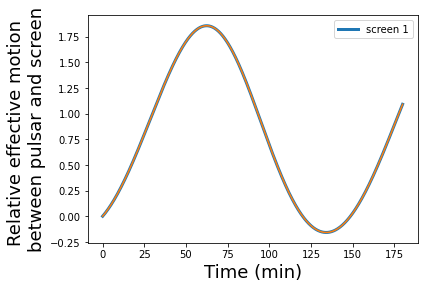

In [11]:
%matplotlib inline
plt.plot(t, (rsp - rsp[0]) / params[-1].to(u.Mm), lw = 3, label = 'screen 1' )
plt.plot( t, Ad_projection_unitless(t.to(u.hour).value, nu, phase, A_real, delta_real) )

# plt.plot(t, (yy2 - yy2[0]) * 325, '--', lw = 3)

plt.ylabel('Relative effective motion \nbetween pulsar and screen', fontsize = 18)
plt.xlabel('Time (min)', fontsize = 18)
plt.legend()
plt.tight_layout()
plt.show()

## Plot dynamic spectrum

Text(0.5, 0, 'time $t$ ($\\mathrm{h}$)')

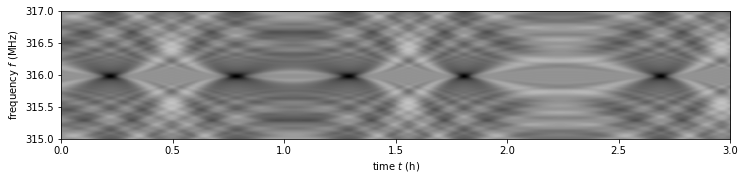

In [12]:
plt.figure(figsize=(12., 8.))

plt.subplot(3,1,1)
plt.imshow( (ds),
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=axis_extent(ts) + axis_extent(fs), vmin=0.)
plt.ylabel(rf"frequency $f$ ({fs.unit.to_string('latex')})")
plt.xlabel(rf"time $t$ ({ts.unit.to_string('latex')})")

## New: remap the dynamic spectrum by the orbital motion

In [13]:
res_t, res_pos, res_dyn, res_tau, res_fd, res_CS = resampler_given_Ad( A = A_real    , 
                                                                      c = delta_real , 
                                                                      time0 = ts, 
                                                                      nu = nu, 
                                                                      phase = phase, 
                                                                      dyn2 = ds, 
                                                                      freq = fs, 
                                                                      delt = 0.1 )

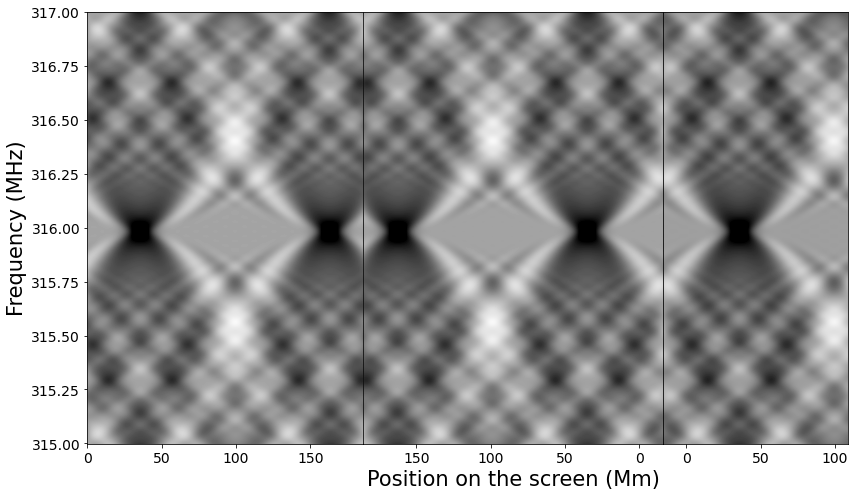

In [14]:
relative_widths = [np.abs(x[0] - x[-1]).value for x in res_pos]
total_width = sum(relative_widths)
relative_widths = [width / total_width for width in relative_widths]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(res_pos), figsize=(sum(relative_widths) * 12, 7), 
                         gridspec_kw={'width_ratios': relative_widths,'wspace': 0 })

# plt.tick_params(axis='both', which='major', labelsize=14)

# Plot data for each subplot
for i, (x, ax) in enumerate(zip(res_pos, axes)):
    ax.imshow(res_dyn[i],
             origin = 'lower',
             aspect = 'auto',
#              interpolation = None,
              cmap = 'gray_r',
             extent = ext_find(res_pos[i], fs), 
              vmin=np.nanmean(res_dyn[i]) - 3 * np.nanstd(res_dyn[i]),
             vmax =np.nanmean(res_dyn[i]) + 3 * np.nanstd(res_dyn[i]))  # Replace this with your actual plot data
#     ax.set_title(f'Region {i + 1}')
    fig.subplots_adjust(wspace=-10, hspace=0.35)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if i ==0:
        ax.set_ylabel('Frequency (MHz)', fontsize = 21)
    else:
        ax.set_yticks([])
    if i == len(res_pos)//2:
        ax.set_xlabel('Position on the screen (Mm)', fontsize = 21)



plt.tight_layout()
plt.show()

## Plot secondary spectrumm

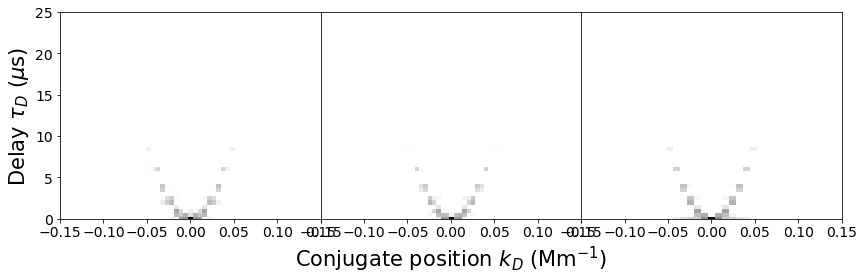

In [15]:
conjugate_stuff = []

plt.figure(figsize = (12,4))
res_tau = res_tau.to(u.us)
# plt.ylabel('Delay $\\tau_D$ ($\mu$s)', fontsize = labsize)
# plt.xlabel('Doppler shift $f_D$ (mHz)', fontsize = labsize)
for i in range(len(res_t)):
    plt.subplot(1, len(res_t), i+1)
    plt.tight_layout()
    
    if i == 0:
        ylabels = 'Delay $\\tau_D$ ($\mu$s)'
        plt.ylabel(ylabels, fontsize = 21)
    else:
        ylabels = None
        plt.subplots_adjust(wspace=0, hspace=0.35)
        plt.yticks([])
    if i == 1:
        plt.xlabel('Conjugate position $k_D$ (Mm$^{-1}$)', fontsize = 21)
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    alpha_nu = 0.25
    alpha_t = 0.5  # Bit larger so nu-t transform also is OK.
    taper = (tukey(res_dyn[i].shape[-1], alpha=alpha_nu)
             * tukey(res_dyn[i].shape[0], alpha=alpha_t)[:, np.newaxis])

    ds_tap = (res_dyn[i] - 1.) * taper + 1.
    
    conjspec = np.fft.fft2( ds_tap / ds_tap.mean() )
    conjspec /= conjspec[0, 0]
    conjspec = np.fft.fftshift(conjspec)
    
    taus = np.fft.fftshift(np.fft.fftfreq(fs.size, fs[1]-fs[0])).to(u.us)
    fds = np.fft.fftshift(np.fft.fftfreq(res_t[i].size,  res_t[i][1] - res_t[i][0]  )).to(u.mHz)
    fds = np.fft.fftshift(np.fft.fftfreq(res_pos[i].size,  res_pos[i][1] - res_pos[i][0]  )).to(1/u.Mm)
    SS = np.abs(conjspec)**2 
    
    if i == 1:
        conjugate_stuff += [ fds, taus, SS]
        
    
    plt.imshow(SS, 
       norm=LogNorm(vmin=1.e-5, vmax=1.), 
       origin='lower',
       aspect='auto',
       cmap='gray_r', extent=axis_extent(fds) + axis_extent(taus))
    plt.ylim(0,25)
    xlimit = 0.15
    plt.xlim((- xlimit , xlimit))
    


## Select parameters to use for analysis

In [16]:
#dynamic spectrum
dsp = ds
#time array
tsp = ts
#frequency array
fsp = fs

#unit used for delays 
fconj_unit = u.us

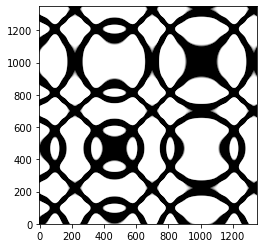

In [17]:
n = dsp /dsp.mean()-1.

c = (n.T @ n) / np.sqrt((n**2).sum(0) * (n**2).sum(0)[:, np.newaxis])
plt.imshow(c, origin='lower', vmin=-0.1, vmax=0.3, cmap='Greys')

In [18]:
# Easier to see in smoothed dynamic spectrum
sp = 3

ns = n[:, :(n.shape[1] // sp) * sp].reshape(n.shape[0], -1, sp).mean(-1)
tss = tsp[:(n.shape[1] // sp) * sp].reshape(-1, sp).mean(-1)

dtaus = np.fft.rfft(ns, axis=0)
taus = np.fft.rfftfreq(ns.shape[0], fsp[1]-fsp[0]).to(fconj_unit)


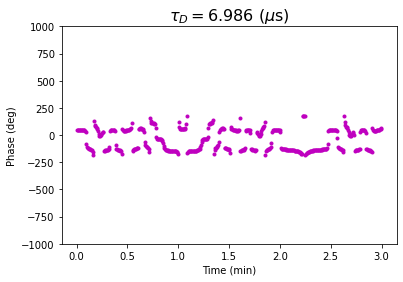

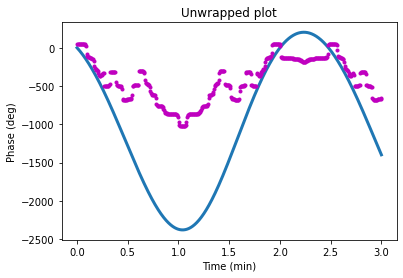

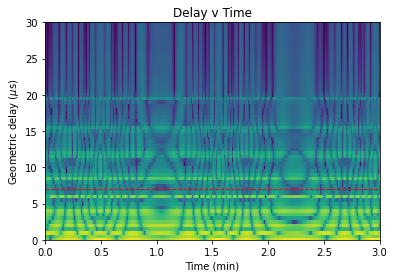

In [19]:
tau_sel = 14



# real, imag, abs, and angle as a function of time.
f = dtaus[tau_sel]


e_f = dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2)  # Noise in real, imag comp.
a_corr = np.sqrt(np.maximum(f.real**2 + f.imag**2 - 2*e_f**2,
                            (e_f/np.pi)**2))
ang = np.degrees(np.angle(f)) << u.deg

unwrapped = np.unwrap(ang)
e_ang = np.degrees(e_f / a_corr) * 1e-2 << u.deg


plt.errorbar(tss, ang, e_ang, c='m', fmt='.')
# plt.errorbar(tss, unwrapped, e_ang, c='m', fmt='.')

plt.ylim(-1000,1000)
plt.title('Wrapped plot')
plt.xlabel('Time (min)')
plt.ylabel('Phase (deg)')



plt.title('$\\tau_D = $' + d2str(fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :][tau_sel].value,3) + " ($\mu$s)", fontsize = 16)

plt.show()


plt.plot(ts, -(rsp - rsp[0]) * 3.7, lw = 3  )
plt.errorbar(tss, unwrapped, e_ang, c='m', fmt='.')

plt.title('Unwrapped plot')
plt.xlabel('Time (min)')
plt.ylabel('Phase (deg)')

plt.show()


plt.imshow(2*np.log10(np.abs(dtaus[:-1])), aspect='auto', origin='lower', vmin=-4, interpolation='none',
          extent = ext_find( tss, fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :]) )

plt.ylim(0,30)
plt.axhline(y =fft_axis(fs, fconj_unit)[-fs.shape[0] // 2 :][tau_sel].value, color = 'red', ls = '--', linewidth = 1 )


plt.title('Delay v Time')
plt.xlabel('Time (min)')
plt.ylabel('Geometric delay ($\\mu$s)')


plt.show()

In [20]:
def wrap180(a):
    return (a + 0.5*u.cy) % (1*u.cy) - 0.5*u.cy

def phase_search_fit_new(t_tmp, nu_tmp, phase_tmp, spp, 
                     signal, err_f, err_ths, 
                     ts_lim_bot, ts_lim_top, fit_lim_bot, fit_lim_top, 
                     A, d, plots = True, Bmin = -90, Bmax = 90, Bn = 200):
    """
    Function to compute the best parameter amplitude B that follows a model for the 
    phase delay:
    signal = amplitude * e^(i * (B * r(t) + c) )
    where B is the amplitude that is being searched for
    r(t) is the projected motion (intergal in time of effective velocity)
    c is a constant phase offset 
    """
    
    #resampling the time, phase, and true anomaly
    t = t_tmp[:(t_tmp.shape[0] // spp) * spp].reshape(-1, spp).mean(-1)
    phase_r = phase_tmp[:(t_tmp.shape[0] // spp) * spp].reshape(-1, spp).mean(-1)
    nu_r = nu_tmp[:(t_tmp.shape[0] // spp) * spp].reshape(-1, spp).mean(-1)
    
    #getting error estimates
    ang = np.degrees(np.angle(signal)) << u.deg
    a_corr = np.sqrt(np.maximum(signal.real**2 + signal.imag**2 - 2*err_f**2,
                                (err_f/np.pi)**2))
    e_ang = np.degrees(err_f / a_corr) << u.deg
    #getting indices of data points that are within errors and within a specified time frame
    f_ind = (e_ang < err_ths * u.deg) & (t <= ts_lim_top ) & (t >= ts_lim_bot)
    f_ind_fit = (e_ang < err_ths * u.deg) & (t <= fit_lim_top ) & (t >= fit_lim_bot)
    
    
    #function to maximize 
    def objective_function(B, tt, y_data):
    
        model = np.exp( -1j  * B * Ad_projection_unitless(t = tt, 
                                   nu = nu_r.value, 
                                   phase = phase_r, 
                                   A = A, 
                                   delta = d ) )[f_ind]


        product = y_data * model #/ (e_ang[f_ind].to(u.rad)).value

        return np.abs( np.sum(product ) )
    
    #function to plot the phases on a angle basis
    def b_model3(tt, B):
        return np.degrees( wrap180( B * Ad_projection_unitless(t = tt, 
                                       nu = nu_r.value, 
                                       phase = phase_r, 
                                       A = A, 
                                       delta = d) * u.rad) ).value[f_ind]
    
    #function to plot the phases with the inferred phase 
    def b_model22(tt, B, phi0):
        return np.degrees( wrap180( phi0 + B * Ad_projection_unitless(t = tt, 
                                       nu = nu_r.value, 
                                       phase = phase_r, 
                                       A = A, 
                                       delta = d ) * u.rad) ).value[f_ind]
    
    #function to plot the phases without the indeces
    def b_model_complete(tt, B, phi0):
        return np.degrees( wrap180( phi0 + B * Ad_projection_unitless(t = tt, 
                                       nu = nu_tmp.value, 
                                       phase = phase_tmp, 
                                       A = A, 
                                       delta = d ) * u.rad) )
    
    #running a maximization scheme over B
    B_stor = []
    B_arr = np.linspace(Bmin,Bmax,Bn)
    
    for i in range(len(B_arr)):
        B_stor += [ objective_function(B = B_arr[i], 
                                       tt = t, 
                                       y_data = signal[f_ind], 
                                       ) ]
        
    
    Bmax = B_arr[ np.argmax(B_stor) ]
    
    
    if plots == True: 
        
        #Parameter search over B
        #---------------------------------------------------------------
        plt.title('Inferred Amplitude: '+ d2str(Bmax,3) )
        plt.plot(B_arr, B_stor)
        
        plt.xlabel('B', fontsize = 14)
        plt.ylabel('Power', fontsize = 14)
        plt.show()
        
        #derotated phases
        #---------------------------------------------------------------
        derophase_tmp = np.angle( signal[f_ind] * np.exp( -1j  * Bmax * Ad_projection_unitless(t = t, 
                                   nu = nu_r, 
                                   phase = phase_r, 
                                   A = A, 
                                   delta = d ) )[f_ind] ).value
        
        derophase_fit = np.angle( signal[f_ind_fit] * np.exp( -1j  * Bmax * Ad_projection_unitless(t = t, 
                                   nu = nu_r, 
                                   phase = phase_r, 
                                   A = A, 
                                   delta = d ) )[f_ind_fit] ).value
        derophase_fit2 = np.copy(derophase_fit)
        derophase_tmp2 = np.copy(derophase_tmp)
        
        derophase_fit2[derophase_fit2 < 0.] += 2 * np.pi
        derophase_tmp2[derophase_tmp2 < 0.] += 2 * np.pi
        
        w_fit = e_ang[f_ind_fit].to(u.rad).value
        phi_fit = np.sum( w_fit * derophase_fit2 ) / np.sum(w_fit) 
        phi_err = np.std(derophase_fit2)**0.5
        
        
        plt.errorbar( t[f_ind], derophase_tmp2, e_ang[f_ind].to(u.rad).value, c='m', fmt='.' ) 
        plt.errorbar( t[f_ind_fit], derophase_fit2, e_ang[f_ind_fit].to(u.rad).value, c='b', fmt='.' )
        
        plt.axvline(x =  fit_lim_bot, c = 'k' )
        plt.axvline(x =  fit_lim_top, c = 'k' )
        
        plt.axhline(y = phi_fit, c = 'k')
        plt.axhline(y = phi_fit + phi_err, ls = '--', c = 'k')
        plt.axhline(y = phi_fit - phi_err, ls = '--', c = 'k')
        
        plt.title('De-rotated Phases $\\phi = $' + d2str(phi_fit,3) + '±'+ d2str(phi_err,3))
        plt.xlim(t[0], t[-1])
        plt.xlabel('Time (hour)')
        plt.ylabel('Phases (deg)')
        plt.ylim(0, 2 * np.pi)
        plt.show()
        
        
        #plot of the model and data 
        #---------------------------------------------------------------
        plt.errorbar(t[f_ind], ang[f_ind], e_ang[f_ind] , c='m', fmt='.')
        
        plt.axvline(x =  fit_lim_bot, c = 'k' )
        plt.axvline(x =  fit_lim_top, c = 'k' )
        plt.errorbar(t[f_ind_fit], ang[f_ind_fit], e_ang[f_ind_fit] , c='b', fmt='.')
        
        
#         plt.plot(t[f_ind], 
#                  b_model22( t, Bmax, np.median(phase_tmp * u.deg.to(u.rad)) * u.deg )
#                 )
        plt.plot(t_tmp, 
                 b_model_complete( t_tmp, Bmax, phi_fit * u.rad  )
                )


        ylimzzz = 1e3
        plt.ylim( - ylimzzz, ylimzzz)
        plt.title('Data - model')
        plt.xlim(t[0], t[-1])
        plt.xlabel('Time (hour)')
        plt.ylabel('Phases (deg)')
        plt.show()
        
        #plot of the residuals
        #---------------------------------------------------------------
        #computing the residuals with respect to the model
        res = b_model22(t, Bmax, phi_fit * u.rad ) - ang[f_ind].value
        
        plt.errorbar(t[f_ind], res , e_ang[f_ind].value , c='m', fmt='.')
        
        
        plt.axvline(x =  fit_lim_bot, c = 'k' )
        plt.axvline(x =  fit_lim_top, c = 'k' )
        
        ylimzzz = 750
        plt.ylim( - ylimzzz, ylimzzz)
        plt.title('Residuals')
        plt.xlim(t[0], t[-1])
        plt.xlabel('Time (hour)')
        plt.ylabel('Phases (deg)')
        plt.show()
        
        dero_sig = signal[f_ind] * np.exp( -1j  * Bmax * Ad_projection_unitless(t = t, 
                                   nu = nu_r, 
                                   phase = phase_r, 
                                   A = A, 
                                   delta = d ) )[f_ind]
        
        plt.plot( dero_sig.real, dero_sig.imag, 'o' )
    

#     return np.sum(np.square(res) ) / len(res)

    w = 1 / e_ang[f_ind].value

    q1 = np.median(np.abs(res)) / len(res) 
    q2 = np.median(res**2) / len(res) 
    q3 = np.sum( w * np.abs( res ) ) / np.sum(w) / len(res) 
    
    return q1, q2, q3


## Doing a search over B, assuming we have the correct parameters for A, $\delta$ (which we do, since we have the real parameters from the simulation)

## New: Use the arc to view which delay you're using

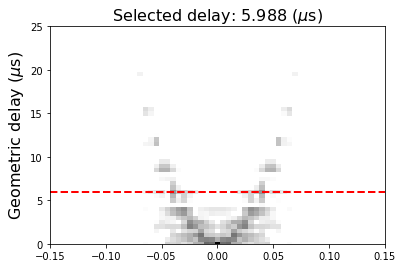

In [21]:
tau_sel = 12


fds, taus, SS = conjugate_stuff

plt.imshow(SS, 
       norm=LogNorm(vmin=1.e-7, vmax=1.), 
       origin='lower',
       aspect='auto',
       cmap='gray_r', extent=axis_extent(fds) + axis_extent(taus))
plt.ylim(0,25)
xlimit = 0.15
plt.xlim((- xlimit , xlimit))

plt.axhline(y =fft_axis(fs, fconj_unit)[-fs.shape[0] // 2 :][tau_sel].value, color = 'red', ls = '--', linewidth = 2 )


plt.ylabel('Geometric delay ($\\mu$s)', fontsize = 16)
plt.title('Selected delay: ' + d2str(fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :][tau_sel].value,3) + " ($\mu$s)", fontsize = 16 )

plt.show()

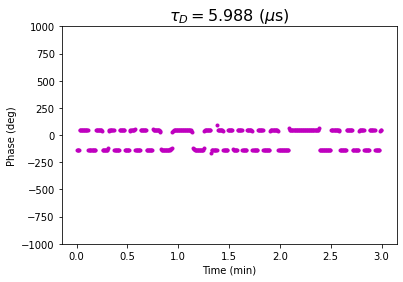

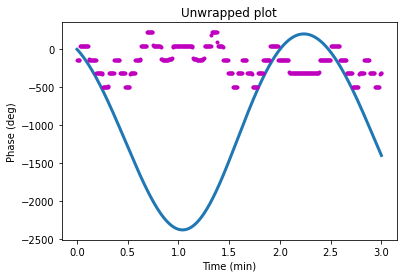

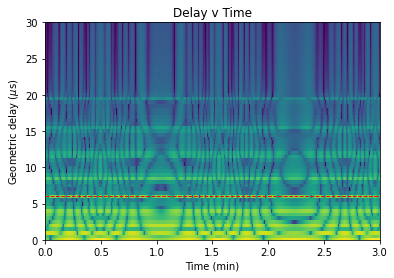

In [22]:
# Easier to see in smoothed dynamic spectrum
sp = 3

ns = n[:, :(n.shape[1] // sp) * sp].reshape(n.shape[0], -1, sp).mean(-1)
tss = tsp[:(n.shape[1] // sp) * sp].reshape(-1, sp).mean(-1)

dtaus = np.fft.rfft(ns, axis=0)
taus = np.fft.rfftfreq(ns.shape[0], fsp[1]-fsp[0]).to(fconj_unit)




# real, imag, abs, and angle as a function of time.
f = dtaus[tau_sel]


e_f = dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2)  # Noise in real, imag comp.
a_corr = np.sqrt(np.maximum(f.real**2 + f.imag**2 - 2*e_f**2,
                            (e_f/np.pi)**2))
ang = np.degrees(np.angle(f)) << u.deg

unwrapped = np.unwrap(ang)
e_ang = np.degrees(e_f / a_corr) * 1e-2 << u.deg


plt.errorbar(tss, ang, e_ang, c='m', fmt='.')
# plt.errorbar(tss, unwrapped, e_ang, c='m', fmt='.')

plt.ylim(-1000,1000)
plt.title('Wrapped plot')
plt.xlabel('Time (min)')
plt.ylabel('Phase (deg)')



plt.title('$\\tau_D = $' + d2str(fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :][tau_sel].value,3) + " ($\mu$s)", fontsize = 16)

plt.show()


plt.plot(ts, -(rsp - rsp[0]) * 3.7, lw = 3  )
plt.errorbar(tss, unwrapped, e_ang, c='m', fmt='.')

plt.title('Unwrapped plot')
plt.xlabel('Time (min)')
plt.ylabel('Phase (deg)')

plt.show()


plt.imshow(2*np.log10(np.abs(dtaus[:-1])), aspect='auto', origin='lower', vmin=-4, interpolation='none',
          extent = ext_find( tss, fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :]) )

plt.ylim(0,30)
plt.axhline(y =fft_axis(fs, fconj_unit)[-fs.shape[0] // 2 :][tau_sel].value, color = 'red', ls = '--', linewidth = 1 )


plt.title('Delay v Time')
plt.xlabel('Time (min)')
plt.ylabel('Geometric delay ($\\mu$s)')


plt.show()

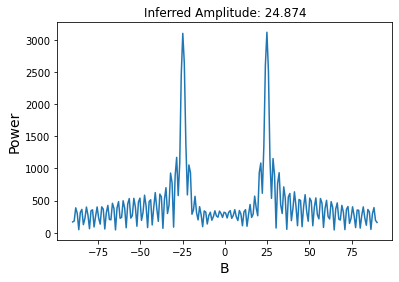

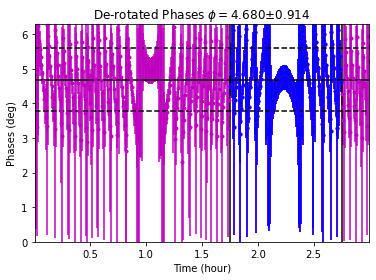

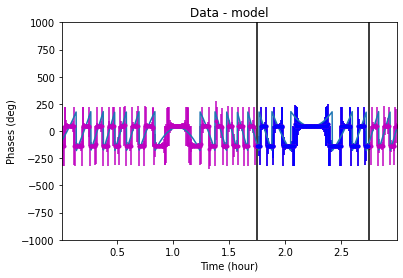

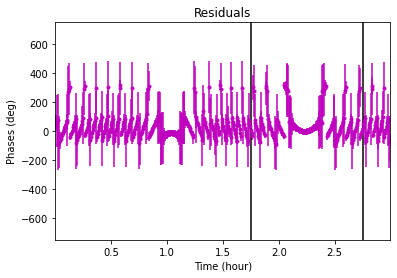

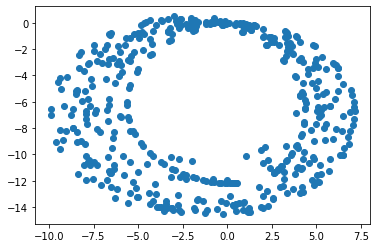

In [23]:
#max error tolerance (degrees)
e_ths = 190

phase_search_fit_new(ts.value , 
                  nu, 
                  phase, 
                  sp, 
                  dtaus[tau_sel], 
                  dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2) , 
                  e_ths, 
                  ts_lim_bot = ts.value[0] , 
                  ts_lim_top = ts.value[-1] ,
                  fit_lim_bot = 1.75,
                  fit_lim_top = 2.75,
                  A = A_real, 
                  d = delta_real, 
                  plots = True,
                  Bmin = -90,
                  Bmax = 90,
                  Bn = 200)
plt.show()

## Theoretical value for $|B|$

## $$ B = \frac{\pi \nu}{c}  \frac{d_s}{d_p - d_s} a \sqrt{  \cos^2(\Delta \Omega) + \cos^2(i_p) \sin^2(\Delta \Omega)  } \sqrt{\frac{2c (d_p - d_s)}{d_p d_s}}  \cdot \tau_D^{1/2}$$

In [24]:
#semimajor axis
sma = 1.410090245 * u.s * const.c

#In this case, since the angle of the normal that used was 65 degrees, xi = 90 - 65 degrees
D_Omega = (90-65) * u.deg - Op

#delay used
Td = fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :][tau_sel]

In [25]:
Td = fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :][tau_sel]

B_real = ( (2 * np.pi * np.mean(fs) / const.c * 
   d_s / (d_p - d_s) * sma * np.sqrt( np.cos(D_Omega)**2 + np.sin(D_Omega)**2 * np.cos(inc)**2 )
   * np.sqrt(2 * const.c  * (d_p - d_s)/ (d_p*d_s) )) 
   * Td **0.5 ).to(u.one)

B_real

<Quantity 24.74011856>

## Example of a symmetric arc manifesting for a single delay

## Clealy two peaks

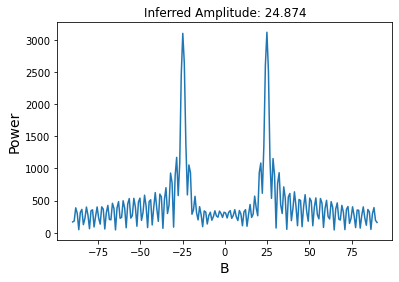

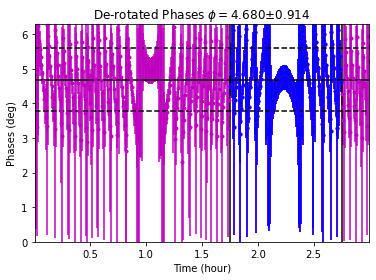

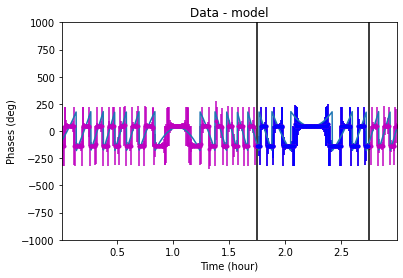

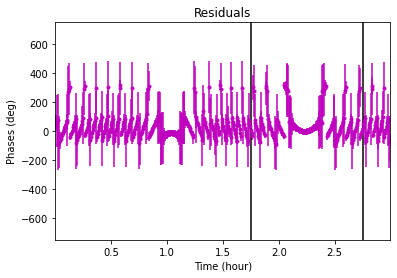

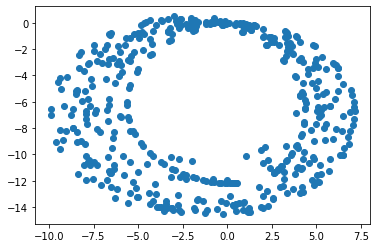

In [26]:
#max error tolerance (degrees)

phase_search_fit_new(ts.value , 
                  nu, 
                  phase, 
                  sp, 
                  dtaus[tau_sel], 
                  dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2) , 
                  e_ths, 
                  ts_lim_bot = ts.value[0] , 
                  ts_lim_top = ts.value[-1] ,
                  fit_lim_bot = 1.75,
                  fit_lim_top = 2.75,
                  A = A_real, 
                  d = delta_real, 
                  plots = True,
                  Bmin = -90,
                  Bmax = 90,
                  Bn = 200)
plt.show()

## Right peak (positive B)

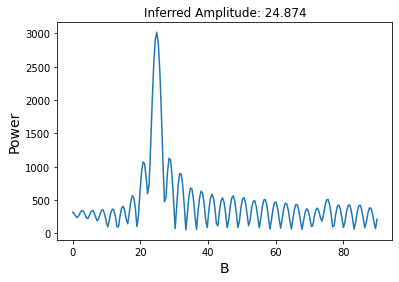

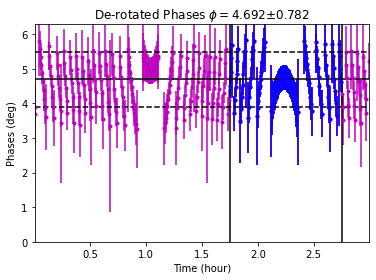

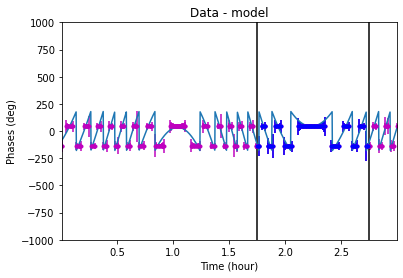

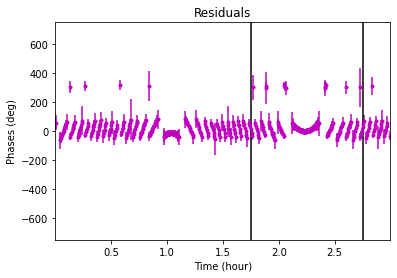

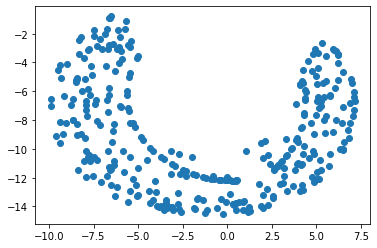

In [27]:
#max error tolerance (degrees)
e_ths = 150

phase_search_fit_new(ts.value , 
                  nu, 
                  phase, 
                  sp, 
                  dtaus[tau_sel], 
                  dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2) , 
                  e_ths, 
                  ts_lim_bot = ts.value[0] , 
                  ts_lim_top = ts.value[-1] ,
                  fit_lim_bot = 1.75,
                  fit_lim_top = 2.75,
                  A = A_real, 
                  d = delta_real, 
                  plots = True,
                  Bmin = 0,
                  Bmax = 90,
                  Bn = 200)
plt.show()

## Left peak (negative peak)

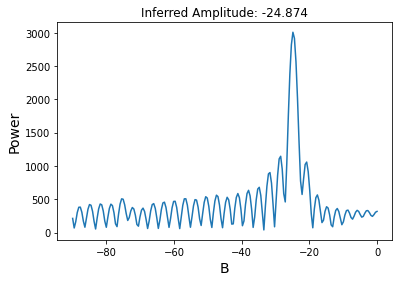

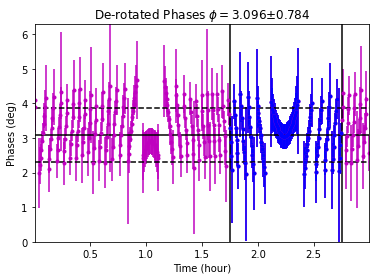

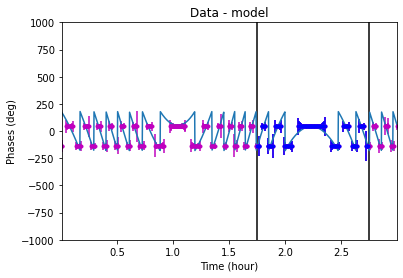

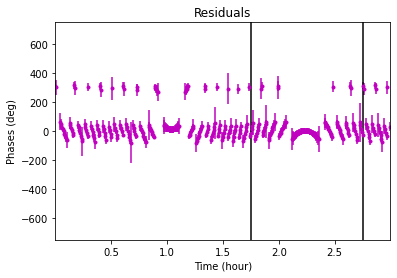

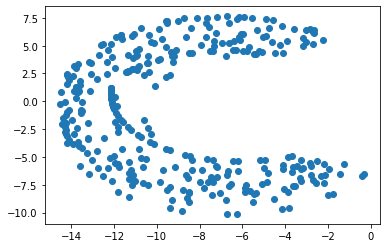

In [28]:
#max error tolerance (degrees)
e_ths = 150

phase_search_fit_new(ts.value , 
                  nu, 
                  phase, 
                  sp, 
                  dtaus[tau_sel], 
                  dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2) , 
                  e_ths, 
                  ts_lim_bot = ts.value[0] , 
                  ts_lim_top = ts.value[-1] ,
                  fit_lim_bot = 1.75,
                  fit_lim_top = 2.75,
                  A = A_real, 
                  d = delta_real, 
                  plots = True,
                  Bmin = -90,
                  Bmax = 0,
                  Bn = 200)
plt.show()

## Value of $B$ for reference

In [29]:
Td = fft_axis(fsp, fconj_unit)[-fsp.shape[0] // 2 :][tau_sel]

B_real = ( (2 * np.pi * np.mean(fs) / const.c * 
   d_s / (d_p - d_s) * sma * np.sqrt( np.cos(D_Omega)**2 + np.sin(D_Omega)**2 * np.cos(inc)**2 )
   * np.sqrt(2 * const.c  * (d_p - d_s)/ (d_p*d_s) )) 
   * Td **0.5 ).to(u.one)

B_real

<Quantity 24.74011856>

## Can then do a search over B, A and $\delta$ to find the best set of params

there's a set of values for A, B and $\delta$ that will maximize the power

## Optional: here's an example of how that would work

In [19]:
def phase_search_Ad_pwr(t_tmp, nu_tmp, phase_tmp, spp, 
                     signal, err_f, err_ths, 
                     ts_lim_bot, ts_lim_top, fit_lim_bot, fit_lim_top, 
                     A, d, plots = False, Bmin = -90, Bmax = 90, Bn = 200):
    """
    Function to compute the best parameter amplitude B that follows a model for the 
    phase delay:
    signal = A * e^(i * (B * r(t) + c) )
    where B is the amplitude that is being searched for
    r(t) is the projected motion (intergal in time of effective velocity)
    c is a constant phase offset 
    """
    
    #resampling the time, phase, and true anomaly
    t = t_tmp[:(t_tmp.shape[0] // spp) * spp].reshape(-1, spp).mean(-1)
    phase_r = phase_tmp[:(t_tmp.shape[0] // spp) * spp].reshape(-1, spp).mean(-1)
    nu_r = nu_tmp[:(t_tmp.shape[0] // spp) * spp].reshape(-1, spp).mean(-1)
    
    #getting error estimates
    ang = np.degrees(np.angle(signal)) << u.deg
    a_corr = np.sqrt(np.maximum(signal.real**2 + signal.imag**2 - 2*err_f**2,
                                (err_f/np.pi)**2))
    e_ang = np.degrees(err_f / a_corr) << u.deg
    #getting indices of data points that are within errors and within a specified time frame
    f_ind = (e_ang < err_ths * u.deg) & (t <= ts_lim_top ) & (t >= ts_lim_bot)
    f_ind_fit = (e_ang < err_ths * u.deg) & (t <= fit_lim_top ) & (t >= fit_lim_bot)
    
    
    #function to maximize 
    def objective_function(B, tt, y_data):
    
        model = np.exp( -1j  * B * Ad_projection_unitless(t = tt, 
                                   nu = nu_r.value, 
                                   phase = phase_r, 
                                   A = A, 
                                   delta = d ) )[f_ind]


        product = y_data * model #/ (e_ang[f_ind].to(u.rad)).value

        return np.abs(  np.sum( product ) ), np.real(  np.sum( product ) )

    
    #function to plot the phases with the inferred phase 
    def b_model22(tt, B, phi0):
        return np.degrees( wrap180( phi0 + B * Ad_projection_unitless(t = tt, 
                                       nu = nu_r.value, 
                                       phase = phase_r, 
                                       A = A, 
                                       delta = d ) * u.rad) ).value[f_ind]
    
    #function to plot the phases without the indeces
    def b_model_complete(tt, B, phi0):
        return np.degrees( wrap180( phi0 + B * Ad_projection_unitless(t = tt, 
                                       nu = nu_tmp.value, 
                                       phase = phase_tmp, 
                                       A = A, 
                                       delta = d ) * u.rad) )
    
    #running a maximization scheme over B
    B_stor = []
    B_arr = np.linspace(Bmin,Bmax,Bn)
    
    for i in range(len(B_arr)):
        
        btmp_powr, btmp_real = objective_function(B = B_arr[i], 
                                       tt = t, 
                                       y_data = signal[f_ind], 
                                       )
        
        B_stor += [ btmp_powr ]
        
    #getting the max value of B
    Bmax = B_arr[ np.argmax(B_stor) ]
    signal_pwr = B_stor[ np.argmax(B_stor) ].value
    
    #derotating the signal
    derophase_fit = np.angle( signal[f_ind_fit] * np.exp( -1j  * Bmax * Ad_projection_unitless(t = t, 
                               nu = nu_r, 
                               phase = phase_r, 
                               A = A, 
                               delta = d ) )[f_ind_fit] ).value
    
    derophase_fit2 = np.copy(derophase_fit)
    
    #rescaling by one rotation
    derophase_fit2[derophase_fit2 < 0.] += 2 * np.pi
    
    #computing the standard deviation
    phi_err = np.std(derophase_fit2)**0.5
    
    #computing the angle of the shift
    w_fit = e_ang[f_ind_fit].to(u.rad).value
    phi_fit = np.sum( w_fit * derophase_fit2 ) / np.sum(w_fit) 
    
    return Bmax, signal_pwr, phi_fit, B_arr, B_stor

In [22]:

def heatmap_pwr_plotter( array_2_plot, A_arr, d_arr, plots = False, norm = 'default', A_real = False, d_real = False ):
    
    inf_A = A_arr[np.where( array_2_plot == np.max( array_2_plot ) )[0]][0]
    inf_d = d_arr[np.where( array_2_plot == np.max( array_2_plot ) )[1]][0].value
    
    if plots == True: 
        plt.figure(figsize=(8,7))

        if norm == 'log':
            # Display the matrix directly using imshow
            im = plt.imshow(array_2_plot.T, 
                            cmap='RdYlGn',
                            norm=LogNorm(vmin=np.min(array_2_plot), vmax=np.max(array_2_plot)),
                            extent=[A_arr.min(), A_arr.max(), 
                                    d_arr.min().value, d_arr.max().value],
                            aspect='auto', origin='lower')
        else:
            # Display the matrix directly using imshow
            im = plt.imshow(array_2_plot.T, 
                            cmap='RdYlGn',
                            vmin=np.min(array_2_plot), vmax=np.max(array_2_plot),
                            extent=[A_arr.min(), A_arr.max(), 
                                    d_arr.min().value, d_arr.max().value],
                            aspect='auto', origin='lower')       


        plt.colorbar(im, label='Power')
        plt.title("Parameter inference from Power Maximization", fontsize=14)
        plt.ylabel('$\delta$', fontsize=16)
        plt.xlabel('$A$', fontsize=16)

        if (A_real != False) and (d_real != False):
            # Add vertical and horizontal lines
            plt.axvline(x=A_real, color='k', linestyle='--')
            plt.axhline(y=d_real.value, color='k', linestyle='--', label='Real value')

        plt.axvline(x=inf_A, color='r', linestyle='--', lw = 3)
        plt.axhline(y=inf_d, color='r', linestyle='--', lw = 3, label = 'Inferred value')

        plt.legend(fontsize = 14)
    
    return inf_A, inf_d

In [23]:
def simulator_phases(ite, ds_r, ts_r, fs_r, tau_sel, A_sampling_array, d_sampling_array, plots = False):

    ts = np.copy(ts_r.to(u.hour))
    fs = np.copy(fs_r.to(u.MHz))
    ds = np.copy(ds_r)
    
    #addition of gaussian noise
    ds +=  1. * np.random.normal(0., scale = 1.0, size = ds.shape)
    
    dsp = ds
    tsp = ts
    fsp = fs

    fconj_unit = u.us

    n = dsp /dsp.mean()-1.

    
    sp = 3
    e_ths = 360
    #computing important quantities after time resampling
    ns = n[:, :(n.shape[1] // sp) * sp].reshape(n.shape[0], -1, sp).mean(-1)
    dtaus = np.fft.rfft(ns, axis=0)
    taus = np.fft.rfftfreq(ns.shape[0], fs[1]-fs[0]).to(u.us)
    
    
#     A_sampling_array = np.linspace(0.5, 2., 50)
#     d_sampling_array = np.linspace(params[4].value - 0.1, params[4].value + 0.1, 50) * u.rad

    pwr_temp = np.zeros((len(A_sampling_array),len(d_sampling_array)))
    B_tmp = np.copy( pwr_temp )
    # sum_temp = np.zeros((len(A_sampling_array),len(d_sampling_array)))
    # std_temp = np.zeros((len(A_sampling_array),len(d_sampling_array)))



    for A_ind in range(len(A_sampling_array)):
        for d_ind in range(len(d_sampling_array)):

            mmm = phase_search_Ad_pwr(ts.value , 
                                      nu, 
                                      phase, 
                                      sp, 
                                      dtaus[tau_sel], 
                                      dtaus[tau_sel-5:tau_sel+5].std() / np.sqrt(2)  , 
                                      e_ths, 
                                      ts_lim_bot = ts.value[0] , 
                                      ts_lim_top = ts.value[-1] ,
                                      fit_lim_bot = 1.75,
                                      fit_lim_top = 2.75,
                                      A = A_sampling_array[A_ind], 
                                      d = d_sampling_array[d_ind], 
                                      plots = False,
                                      Bmin = -90,
                                      Bmax = 90,
                                      Bn = 200)

            pwr_temp[A_ind, d_ind] = mmm[1]
            B_tmp[A_ind, d_ind] = mmm[0]


    #         sum_temp[A_ind, d_ind] = tmp_vals[2]
    #         std_temp[A_ind, d_ind] = tmp_vals[3]
#     Ainf, dinf = heatmap_pwr_plotter( array_2_plot = pwr_temp, 
#                     A_arr = A_sampling_array, 
#                     d_arr = d_sampling_array, 
#                     A_real = -params[3], 
#                     d_real = params[4],
#                     plots = plots)
    
    return pwr_temp, B_tmp, A_sampling_array, d_sampling_array


In [24]:
timer2 = timer.time()

pwr_temp, B_tmp, A_sampling_array, d_sampling_array = simulator_phases(0,
                                dyns, 
                                 t, 
                                 fs, 
                                tau_sel, 
                                np.linspace(-0.3, 0.3, 25),
                                np.linspace(params[4].value - 0.1, params[4].value + 0.1, 15)*u.rad + np.pi*u.rad,
                                plots = True
                                )

print('Elapsed time: ', timer.time() - timer2 )

Elapsed time:  29.041590690612793


(-0.025000000000000022, 3.153812351881452)

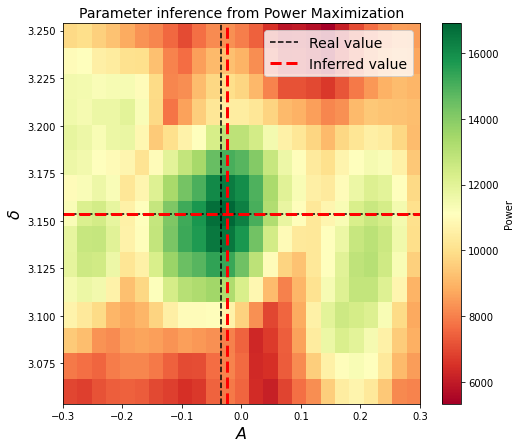

In [25]:
heatmap_pwr_plotter( array_2_plot = pwr_temp, 
                    A_arr = A_sampling_array, 
                    d_arr = d_sampling_array, 
                    A_real = A_real, 
                    d_real = delta_real * u.rad,
                    plots = True)